In [17]:
# ============================================
# 02_Model_Training.ipynb (Ensemble Version)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib

print("✅ Libraries imported successfully.")


✅ Libraries imported successfully.


In [20]:
# ============================================
# Step 2: Load preprocessed dataset
# ============================================

df = pd.read_csv(r"C:\Users\rudra\Desktop\Ml\AlzheimerSpeechDetection\data\cleaned_data.csv")

print("✅ Dataset loaded successfully!")
print("Shape:", df.shape)
df.head()


✅ Dataset loaded successfully!
Shape: (1010, 16)


,duration_sec,chunk_count,ling_pca_1,ling_pca_2,ling_pca_3,ling_pca_4,ling_pca_5,ling_pca_6,ling_pca_7,ling_pca_8,ling_pca_9,ling_pca_10,mfcc_mean,mfcc_std,mfcc_var,label
0,-1.073335,0.585471,-1.380434,-2.071191,-0.280712,-0.443072,-2.344535,-1.668284,0.315490,0.543474,0.409607,-0.696108,0.118150,-0.304765,-0.386399,1
1,0.631371,-0.655018,1.192120,-0.201919,1.273924,-0.285460,-0.873017,0.226213,1.138684,0.307719,0.453946,-0.546963,1.100894,0.622068,0.537442,1
2,-1.475334,-1.120201,0.946772,-1.250882,-0.292259,-0.536916,0.458492,-0.798289,-0.495567,0.718978,-2.543192,-0.255951,0.375442,2.398057,2.797055,1
3,-1.295428,-0.034774,0.775405,-0.303678,0.589791,-0.708858,0.075996,-1.765217,1.639990,0.241049,-0.237863,-0.566084,0.878576,0.462159,0.365546,0
4,-1.775988,-0.344896,-1.474911,0.814418,-0.363681,0.470561,0.977076,-1.158006,1.287601,0.801658,1.051754,-0.450149,1.674216,-0.941891,-0.919887,0


In [21]:
# ============================================
# Step 3: Split data
# ============================================

X = df.drop("label", axis=1)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


Training set: (808, 15), Test set: (202, 15)


In [22]:
# ============================================
# Step 4: Define base models with balanced classes
# ============================================

models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=7, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False, scale_pos_weight=2, random_state=42),
    "LightGBM": LGBMClassifier(class_weight='balanced', random_state=42)
}


In [23]:
# ============================================
# Step 5: Train and evaluate each model
# ============================================

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    }
    results.append(metrics)

results_df = pd.DataFrame(results)
results_df


[LightGBM] [Info] Number of positive: 360, number of negative: 448
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3616
[LightGBM] [Info] Number of data points in the train set: 808, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

C:\Users\rudra\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [18:42:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
0,Logistic Regression,0.490099,0.438095,0.511111,0.471795,0.509623
1,Random Forest,0.594059,0.554054,0.455556,0.500000,0.573909
2,XGBoost,0.539604,0.484211,0.511111,0.497297,0.538393
3,LightGBM,0.554455,0.500000,0.455556,0.476744,0.537004


In [24]:
# ============================================
# Step 6: Voting Ensemble (Soft Voting)
# ============================================

voting_clf = VotingClassifier(
    estimators=[
        ('lr', models["Logistic Regression"]),
        ('rf', models["Random Forest"]),
        ('xgb', models["XGBoost"]),
        ('lgbm', models["LightGBM"])
    ],
    voting='soft',
    n_jobs=-1
)

voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_test)
y_prob_voting = voting_clf.predict_proba(X_test)[:, 1]

voting_results = {
    "Model": "Voting Ensemble",
    "Accuracy": accuracy_score(y_test, y_pred_voting),
    "Precision": precision_score(y_test, y_pred_voting),
    "Recall": recall_score(y_test, y_pred_voting),
    "F1 Score": f1_score(y_test, y_pred_voting),
    "ROC-AUC": roc_auc_score(y_test, y_prob_voting)
}

results_df = pd.concat([results_df, pd.DataFrame([voting_results])], ignore_index=True)
print("✅ Voting Ensemble evaluated successfully.")


✅ Voting Ensemble evaluated successfully.


In [25]:
# ============================================
# Step 7: Stacking Ensemble
# ============================================

base_learners = [
    ('rf', models["Random Forest"]),
    ('xgb', models["XGBoost"]),
    ('lgbm', models["LightGBM"])
]

meta_learner = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=5,
    n_jobs=-1
)

stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)
y_prob_stack = stacking_clf.predict_proba(X_test)[:, 1]

stacking_results = {
    "Model": "Stacking Ensemble",
    "Accuracy": accuracy_score(y_test, y_pred_stack),
    "Precision": precision_score(y_test, y_pred_stack),
    "Recall": recall_score(y_test, y_pred_stack),
    "F1 Score": f1_score(y_test, y_pred_stack),
    "ROC-AUC": roc_auc_score(y_test, y_prob_stack)
}

results_df = pd.concat([results_df, pd.DataFrame([stacking_results])], ignore_index=True)
print("✅ Stacking Ensemble evaluated successfully.")


✅ Stacking Ensemble evaluated successfully.


C:\Users\rudra\AppData\Local\Temp\ipykernel_22688\793486050.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="F1 Score", data=results_df, palette="viridis")


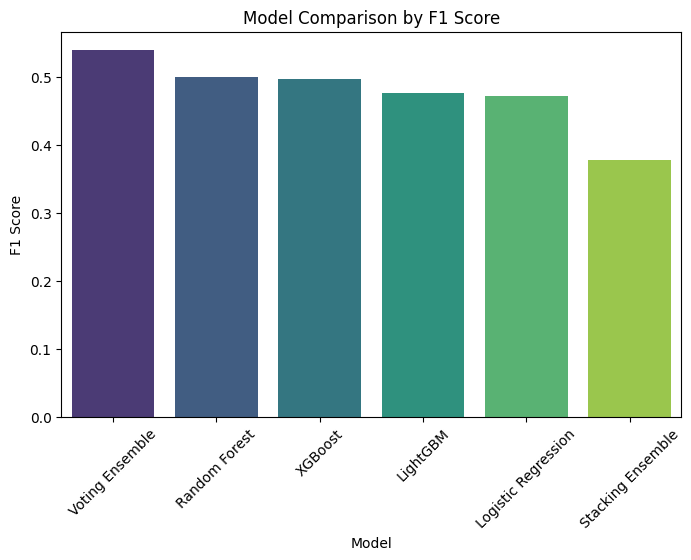

,Model,Accuracy,Precision,Recall,F1 Score,ROC-AUC
4,Voting Ensemble,0.594059,0.545455,0.533333,0.539326,0.551488
1,Random Forest,0.594059,0.554054,0.455556,0.500000,0.573909
2,XGBoost,0.539604,0.484211,0.511111,0.497297,0.538393
3,LightGBM,0.554455,0.500000,0.455556,0.476744,0.537004
0,Logistic Regression,0.490099,0.438095,0.511111,0.471795,0.509623
5,Stacking Ensemble,0.410891,0.356436,0.400000,0.376963,0.447817


In [26]:
# ============================================
# Step 8: Compare model performance
# ============================================

results_df = results_df.sort_values(by="F1 Score", ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="F1 Score", data=results_df, palette="viridis")
plt.title("Model Comparison by F1 Score")
plt.xticks(rotation=45)
plt.show()

results_df


In [30]:
# ============================================
# Step 9: Save best performing model
# ============================================

best_model_name = results_df.iloc[0]["Model"]

if best_model_name == "Voting Ensemble":
    best_model = voting_clf
elif best_model_name == "Stacking Ensemble":
    best_model = stacking_clf
else:
    best_model = models[best_model_name]

joblib.dump(best_model, f"C:\\Users\\rudra\\Desktop\\Ml\\AlzheimerSpeechDetection\\models\\{best_model_name.replace(' ', '_')}_best.pkl")
results_df.to_json(r"C:\Users\rudra\Desktop\Ml\AlzheimerSpeechDetection\results\metrics.json", orient="records")

print(f"✅ Best model saved as: models/{best_model_name.replace(' ', '_')}_best.pkl")
print("✅ Metrics saved to results/metrics.json")


✅ Best model saved as: models/Voting_Ensemble_best.pkl
✅ Metrics saved to results/metrics.json
